In [12]:
!pip install ultralytics -qq

# Object Detecion
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline


import urllib.request
import shutil

In [13]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive

from google.colab import auth

from oauth2client.client import GoogleCredentials

auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.2/78.2 GB disk)


In [15]:
from itertools import chain
from glob import glob
from collections import Counter
from pprint import pprint

id2class_map = {
    '0' : 'paper',
    '1' : 'rock',
    '2' : 'scissor',
    '3' : 'contestant'
}

main_path = "/content/drive/MyDrive/Rock_Paper_Scissors"

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')

def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('valid')
print_class_count('valid')
print_data_size('test')
print_class_count('test')

train data count: 6465
-- data class count
{'0. paper': 1349, '1. rock': 1926, '2. scissor': 1341}

valid data count: 576
-- data class count
{'0. paper': 139, '1. rock': 141, '2. scissor': 120}

test data count: 304
-- data class count
{'0. paper': 72, '1. rock': 65, '2. scissor': 67}



In [16]:
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"/content/drive/MyDrive/Rock_Paper_Scissors"

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''

    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]

    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2

    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)

    return x_min, y_min, x_max, y_max

class2color_map = {
    'paper': (0,255,128),
    'rock': (255,51,51),
    'scissor': (51,255,255),
    'contestant': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):

        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

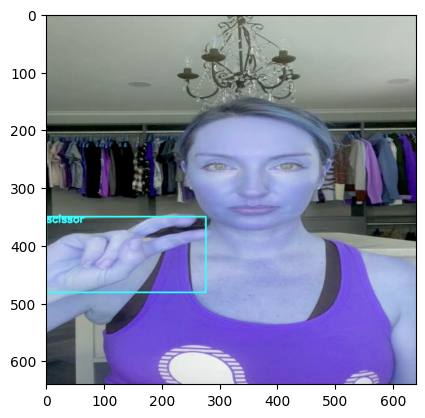

In [17]:
plot_image(image_name='IMG_5636_MOV-4_jpg.rf.11fbae0751c30e0327b71075d7ec84b6')

In [18]:
from ultralytics import YOLO
model = YOLO("yolov9c.pt")
model.info

<bound method Model.info of YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv3): Conv(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (m): Sequential(
              (0): RepBottleneck(
                (cv1): RepConv(
                  (act): SiLU(inplace=True)
                  (conv1): Conv(
                    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                    (act): Identity()
                  )
                  (conv2): Conv(
                    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                    (act): Identity()
                  )
                )
                (cv2): Conv(
                  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
                  (act): SiLU(inplace=True)
                )
              )
            )
          )
          (1): Conv(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
        )
        (cv3): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (cv3): Conv(
              (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (act): SiLU(inplace=True)
            )
            (m): Sequential(
              (0): RepBottleneck(
                (cv1): RepCon

In [19]:
import yaml

with open(os.path.join(main_path,'coco128.yaml'), 'r' ) as file:
    print(file.read())

In [20]:
data = {
    'train' : '/content/drive/MyDrive/Rock_Paper_Scissors/train',
    'val' : '/content/drive/MyDrive/Rock_Paper_Scissors/test',
    'nc' : 4,
    'names' : [
        'paper',
        'rock',
        'scissor',
        'contestant'
    ]
}

with open('/content/drive/MyDrive/Rock_Paper_Scissors/working/data.yaml','w') as file:
    yaml.dump(data,file)

with open('/content/drive/MyDrive/Rock_Paper_Scissors/working/data.yaml','r') as file:
    print(file.read())


names:
- paper
- rock
- scissor
- contestant
nc: 4
train: /content/drive/MyDrive/Rock_Paper_Scissors/train
val: /content/drive/MyDrive/Rock_Paper_Scissors/test



In [21]:
os.environ["WANDB_MODE"] = "disabled"

model.train(
    data = '/content/drive/MyDrive/Rock_Paper_Scissors/working/data.yaml',
    epochs = 20,
    workers = 1,
    batch = 8,
)


Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/content/drive/MyDrive/Rock_Paper_Scissors/working/data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

train: Scanning /content/drive/MyDrive/Rock_Paper_Scissors/train/labels.cache... 6455 images, 2526 backgrounds, 0 corrupt: 100%|██████████| 6465/6465 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Rock_Paper_Scissors/test/labels.cache... 304 images, 118 backgrounds, 0 corrupt: 100%|██████████| 304/304 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      6.12G      1.551      2.795       1.86          0        640: 100%|██████████| 809/809 [21:56<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]

                   all        304        204      0.247      0.123      0.125     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.09G      1.682        2.7      1.942          1        640: 100%|██████████| 809/809 [05:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.53it/s]

                   all        304        204      0.373      0.375       0.34      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.16G      1.621      2.508      1.871          3        640: 100%|██████████| 809/809 [05:48<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.17it/s]

                   all        304        204      0.432      0.386      0.413       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.07G      1.499      2.305      1.796          1        640: 100%|██████████| 809/809 [05:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.08it/s]

                   all        304        204      0.489      0.547      0.596      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.08G      1.393      2.038      1.705          1        640: 100%|██████████| 809/809 [05:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.79it/s]

                   all        304        204      0.551      0.617      0.645      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.07G      1.374      1.911      1.686          2        640: 100%|██████████| 809/809 [05:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.70it/s]

                   all        304        204      0.578      0.615       0.66       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.06G      1.315      1.757      1.646          2        640: 100%|██████████| 809/809 [05:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.11it/s]

                   all        304        204      0.629      0.763      0.784      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.07G      1.254      1.643       1.59          1        640: 100%|██████████| 809/809 [05:47<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.79it/s]

                   all        304        204      0.745      0.743      0.767       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.06G      1.222      1.532      1.566          1        640: 100%|██████████| 809/809 [05:46<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]

                   all        304        204      0.746      0.737      0.827      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.97G      1.163      1.408      1.516          1        640: 100%|██████████| 809/809 [05:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.71it/s]

                   all        304        204      0.784      0.796      0.855      0.603


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
      11/20      6.08G       1.04      1.083      1.482          0        640: 100%|██████████| 809/809 [05:43<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

                   all        304        204      0.839      0.849      0.881      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.08G      1.002     0.9867      1.448          1        640: 100%|██████████| 809/809 [05:40<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        304        204      0.852      0.842      0.895       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.07G     0.9572     0.8997      1.405          1        640: 100%|██████████| 809/809 [05:51<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.48it/s]

                   all        304        204       0.87      0.822      0.893       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.07G     0.9302     0.8414      1.375          1        640: 100%|██████████| 809/809 [05:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]

                   all        304        204      0.843      0.877      0.915      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.07G     0.8799     0.7631      1.322          1        640: 100%|██████████| 809/809 [05:42<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.75it/s]

                   all        304        204      0.909      0.879      0.938      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.08G     0.8444     0.7094      1.298          1        640: 100%|██████████| 809/809 [05:46<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.72it/s]

                   all        304        204      0.884      0.864      0.915      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.07G      0.805     0.6381      1.272          0        640: 100%|██████████| 809/809 [05:50<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]

                   all        304        204      0.884      0.853      0.908      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.13G     0.7801      0.611      1.234          0        640: 100%|██████████| 809/809 [05:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.21it/s]

                   all        304        204      0.916      0.881       0.93       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.09G     0.7324     0.5592      1.203          0        640: 100%|██████████| 809/809 [05:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.05it/s]

                   all        304        204      0.894      0.922      0.938      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.07G     0.7141     0.5179      1.187          1        640: 100%|██████████| 809/809 [06:00<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.18it/s]

                   all        304        204      0.909      0.909      0.944       0.76



20 epochs completed in 2.264 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 51.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:09<00:00,  1.92it/s]


                   all        304        204      0.909      0.909      0.944      0.761
                 paper         72         72      0.894      0.847      0.927       0.71
                  rock         59         65      0.911      0.954      0.948      0.762
               scissor         66         67      0.922      0.925      0.958      0.811
Speed: 0.4ms preprocess, 15.7ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789ad53fe980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [23]:
from ultralytics import YOLO

model = YOLO('/content/runs/detect/train3/weights/best.pt')

In [29]:
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'test', 'images', f'{image_name}.jpg')
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

def label_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image file '{image_path}' not found or could not be loaded.")

    original_shape = image.shape[:2]
    results = model(image)
    labels = results[0].boxes.data.cpu().numpy()
    predicted_labels = []

    for label in labels:
        x_min, y_min, x_max, y_max, confidence, class_id = label[:6]
        x_center = (x_min + x_max) / 2 / original_shape[1]
        y_center = (y_min + y_max) / 2 / original_shape[0]
        width = (x_max - x_min) / original_shape[1]
        height = (y_max - y_min) / original_shape[0]
        predicted_labels.append(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return predicted_labels

def save_labels(labels, label_path):
    with open(label_path, 'w') as file:
        for label in labels:
            file.write(f"{label}\n")

def determine_winner(predicted_labels):
    moves = [label.split()[0] for label in predicted_labels]
    contestant_moves = [id2class_map[move] for move in moves if move in id2class_map and move != '3']

    if len(contestant_moves) != 2:
        return "Invalid detection or number of moves."

    move1, move2 = contestant_moves
    if move1 == move2:
        return "Draw"
    if (move1 == 'rock' and move2 == 'scissor') or (move1 == 'scissor' and move2 == 'paper') or (move1 == 'paper' and move2 == 'rock'):
        return "Contestant 1 wins"
    else:
        return "Contestant 2 wins"


0: 640x640 1 scissor, 51.1ms
Speed: 2.0ms preprocess, 51.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
The predicted labels for the image are saved to: /content/drive/MyDrive/Rock_Paper_Scissors/test/labels/egohands-public-1624972107897_png_jpg.rf.6991f44b248b35d3394482a26fcaeb56.jpg
The winner is: Invalid detection or number of moves.
Prediction ↓

image 1/1 /content/drive/MyDrive/Rock_Paper_Scissors/test/images/egohands-public-1624972107897_png_jpg.rf.6991f44b248b35d3394482a26fcaeb56.jpg: 640x640 1 scissor, 49.7ms
Speed: 2.0ms preprocess, 49.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


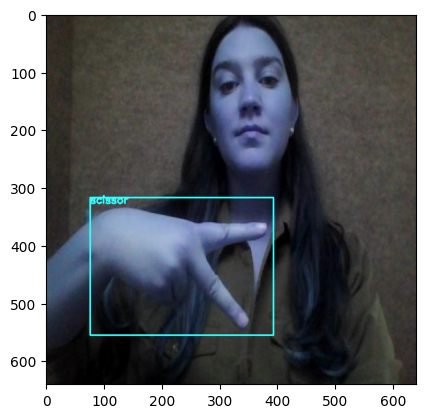

Actual image ↓


In [31]:
image_path = '/content/drive/MyDrive/Rock_Paper_Scissors/test/images/egohands-public-1624972107897_png_jpg.rf.6991f44b248b35d3394482a26fcaeb56.jpg'
label_path = '/content/drive/MyDrive/Rock_Paper_Scissors/test/labels/egohands-public-1624972107897_png_jpg.rf.6991f44b248b35d3394482a26fcaeb56.jpg'

os.makedirs(os.path.dirname(label_path), exist_ok=True)

try:
    predicted_labels = label_image(image_path)
    save_labels(predicted_labels, label_path)
    print(f'The predicted labels for the image are saved to: {label_path}')
    winner = determine_winner(predicted_labels)
    print(f"The winner is: {winner}")
except Exception as e:
    print(f"Error: {e}")

image_name = 'egohands-public-1624972107897_png_jpg.rf.6991f44b248b35d3394482a26fcaeb56'
print('Prediction ↓')
plot_pred_image(image_name=image_name)
print('Actual image ↓')

In [32]:
import locale
locale.getpreferredencoding = lambda: 'UTF-8'

!yolo task=detect mode=predict model=/content/runs/detect/train3/weights/best.pt source='/content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4'


Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c summary (fused): 384 layers, 25322332 parameters, 0 gradients, 102.3 GFLOPs

video 1/1 (frame 1/2612) /content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4: 384x640 (no detections), 145.7ms
video 1/1 (frame 2/2612) /content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4: 384x640 (no detections), 31.5ms
video 1/1 (frame 3/2612) /content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4: 384x640 (no detections), 31.5ms
video 1/1 (frame 4/2612) /content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4: 384x640 (no detections), 32.0ms
video 1/1 (frame 5/2612) /content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4: 384x640 1 paper, 31.4ms
video 1/1 (frame 6/2612) /content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4: 384x640 1 paper, 21.5ms
video 1/1 (frame 7/2612) /content/drive/MyDrive/Rock, Paper, Scissors with GPT-4o.mp4: 384x640 1 paper, 21.4ms
video 1/1 (frame 8

In [40]:
import io
from IPython.display import HTML
from base64 import b64encode
def show_video(file_name, width=640):
  # show resulting deepsort video
  mp4 = open(file_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""

  """.format(width, data_url))

In [47]:
# output object tracking video
path_output = "/content/runs/detect/predict/Rock, Paper, Scissors with GPT-4o.avi"
show_video(path_output, width=960)